Import modules

In [2]:
pip install category_encoders

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from category_encoders import HashingEncoder, OneHotEncoder

Review data

In [5]:
data = pd.read_csv('zillow_df.csv')
data.head()

,pop_rank,city,state,month,year,mean_sales_price,number_of_sales,home_value,market_heat_index,value_surplus
0,83,Akron,OH,2,2008,111182.75,398.0,124307.869610,NaN,-13125.119610
1,83,Akron,OH,3,2008,117496.40,403.0,124112.725495,NaN,-6616.325495
2,83,Akron,OH,4,2008,116325.50,480.0,124067.896104,NaN,-7742.396104
3,83,Akron,OH,5,2008,140846.00,478.0,124246.821831,NaN,16599.178169
4,83,Akron,OH,6,2008,137244.50,603.0,124224.500972,NaN,13019.999028


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28097 entries, 0 to 28096
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pop_rank           28097 non-null  int64  
 1   city               28097 non-null  object 
 2   state              28097 non-null  object 
 3   month              28097 non-null  int64  
 4   year               28097 non-null  int64  
 5   mean_sales_price   28097 non-null  float64
 6   number_of_sales    18372 non-null  float64
 7   home_value         28097 non-null  float64
 8   market_heat_index  12018 non-null  float64
 9   value_surplus      28097 non-null  float64
dtypes: float64(5), int64(3), object(2)
memory usage: 2.1+ MB


In [7]:
data.shape

(28097, 10)

In [8]:
data.describe()

,pop_rank,month,year,mean_sales_price,number_of_sales,home_value,market_heat_index,value_surplus
count,28097.000000,28097.000000,28097.000000,2.809700e+04,18372.000000,2.809700e+04,12018.000000,2.809700e+04
mean,75.977506,6.491903,2016.200555,2.954871e+05,2508.435990,2.495746e+05,63.362373,4.591247e+04
std,48.496695,3.451711,4.921005,2.039826e+05,2667.807877,1.630525e+05,19.628019,6.367005e+04
min,1.000000,1.000000,2008.000000,6.768200e+04,72.000000,4.453395e+04,10.000000,-1.338282e+05
25%,36.000000,3.000000,2012.000000,1.719042e+05,838.750000,1.470214e+05,50.000000,1.468405e+04
50%,71.000000,6.000000,2016.000000,2.326264e+05,1471.000000,2.006046e+05,60.000000,3.166369e+04
75%,110.000000,9.000000,2020.000000,3.391028e+05,3094.250000,2.894352e+05,74.000000,5.590434e+04
max,284.000000,12.000000,2025.000000,2.100472e+06,23983.000000,1.744104e+06,235.000000,1.606645e+06


Handle missing values

In [10]:
data.isna().sum()

pop_rank                 0
city                     0
state                    0
month                    0
year                     0
mean_sales_price         0
number_of_sales       9725
home_value               0
market_heat_index    16079
value_surplus            0
dtype: int64

In [11]:
#fill number_of_sales and market_heat_index with median
data['number_of_sales'] = data['number_of_sales'].fillna(data.groupby('state')['number_of_sales'].transform('median'))
data['market_heat_index'] = data['market_heat_index'].fillna(data.groupby('state')['market_heat_index'].transform('median'))
data.isna().sum()

pop_rank               0
city                   0
state                  0
month                  0
year                   0
mean_sales_price       0
number_of_sales      781
home_value             0
market_heat_index      0
value_surplus          0
dtype: int64

In [12]:
#check where missing number_of_sales values are still occurring
data.groupby('state')['number_of_sales'].apply(lambda x: x.isna().sum())

state
AL      0
AR      0
AZ      0
CA      0
CO      0
CT      0
DE    198
FL      0
GA      0
HI      0
IA      0
ID      0
IL      0
IN      0
KS      0
KY      0
LA      0
MA      0
MD      0
ME    204
MI      0
MN      0
MO      0
MS    379
NC      0
NE      0
NM      0
NV      0
NY      0
OH      0
OK      0
OR      0
PA      0
RI      0
SC      0
TN      0
TX      0
UT      0
VA      0
WA      0
WI      0
Name: number_of_sales, dtype: int64

In [13]:
data.groupby('state')['number_of_sales'].apply(lambda x: x.notnull().sum())

state
AL     704
AR     408
AZ     408
CA    2856
CO     816
CT     612
DE       0
FL    2502
GA     811
HI     204
IA     204
ID     204
IL     612
IN     612
KS     204
KY     408
LA     466
MA     810
MD     367
ME       0
MI     816
MN     204
MO     612
MS       0
NC    1248
NE     204
NM     212
NV     408
NY    1020
OH    1428
OK     408
OR     243
PA    1632
RI     204
SC     816
TN    1015
TX    1802
UT     408
VA     612
WA     408
WI     408
Name: number_of_sales, dtype: int64

In [14]:
#since DE, ME, and MS have no sales value, we'll use knn_imputer() to fill these values
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=12)
data['number_of_sales'] = imputer.fit_transform(data[['number_of_sales']])

In [15]:
data.isna().sum()

pop_rank             0
city                 0
state                0
month                0
year                 0
mean_sales_price     0
number_of_sales      0
home_value           0
market_heat_index    0
value_surplus        0
dtype: int64

In [16]:
#check to see how data was affected
data.describe()

,pop_rank,month,year,mean_sales_price,number_of_sales,home_value,market_heat_index,value_surplus
count,28097.000000,28097.000000,28097.000000,2.809700e+04,28097.000000,2.809700e+04,28097.000000,2.809700e+04
mean,75.977506,6.491903,2016.200555,2.954871e+05,2599.928632,2.495746e+05,62.325924,4.591247e+04
std,48.496695,3.451711,4.921005,2.039826e+05,2495.334769,1.630525e+05,14.482184,6.367005e+04
min,1.000000,1.000000,2008.000000,6.768200e+04,72.000000,4.453395e+04,10.000000,-1.338282e+05
25%,36.000000,3.000000,2012.000000,1.719042e+05,1021.000000,1.470214e+05,54.000000,1.468405e+04
50%,71.000000,6.000000,2016.000000,2.326264e+05,1761.500000,2.006046e+05,61.000000,3.166369e+04
75%,110.000000,9.000000,2020.000000,3.391028e+05,2769.000000,2.894352e+05,68.000000,5.590434e+04
max,284.000000,12.000000,2025.000000,2.100472e+06,23983.000000,1.744104e+06,235.000000,1.606645e+06


This increased the mean and IQR of the number_of_sales but brought them closer to the median

Change month/year to datetime

In [19]:
data['date'] = pd.to_datetime(data[['year', 'month']].assign(day=1), errors='coerce')
data.head()

,pop_rank,city,state,month,year,mean_sales_price,number_of_sales,home_value,market_heat_index,value_surplus,date
0,83,Akron,OH,2,2008,111182.75,398.0,124307.869610,61.0,-13125.119610,2008-02-01
1,83,Akron,OH,3,2008,117496.40,403.0,124112.725495,61.0,-6616.325495,2008-03-01
2,83,Akron,OH,4,2008,116325.50,480.0,124067.896104,61.0,-7742.396104,2008-04-01
3,83,Akron,OH,5,2008,140846.00,478.0,124246.821831,61.0,16599.178169,2008-05-01
4,83,Akron,OH,6,2008,137244.50,603.0,124224.500972,61.0,13019.999028,2008-06-01


In [20]:
#drop month/year columns
data = data.drop(columns=['month', 'year'])
data.head()

,pop_rank,city,state,mean_sales_price,number_of_sales,home_value,market_heat_index,value_surplus,date
0,83,Akron,OH,111182.75,398.0,124307.869610,61.0,-13125.119610,2008-02-01
1,83,Akron,OH,117496.40,403.0,124112.725495,61.0,-6616.325495,2008-03-01
2,83,Akron,OH,116325.50,480.0,124067.896104,61.0,-7742.396104,2008-04-01
3,83,Akron,OH,140846.00,478.0,124246.821831,61.0,16599.178169,2008-05-01
4,83,Akron,OH,137244.50,603.0,124224.500972,61.0,13019.999028,2008-06-01


In [21]:
#confirm no missing values
data.isna().sum()

pop_rank             0
city                 0
state                0
mean_sales_price     0
number_of_sales      0
home_value           0
market_heat_index    0
value_surplus        0
date                 0
dtype: int64

Handle categorical data

In [23]:
#Use hash encoding for city data
#check number of unique values in city column to determine components
data['city'].nunique()

144

In [24]:
encoder = HashingEncoder(n_components=7)
city_transform = encoder.fit_transform(data['city'])
city_transform.head()

,col_0,col_1,col_2,col_3,col_4,col_5,col_6
0,0,1,0,0,0,0,0
1,0,1,0,0,0,0,0
2,0,1,0,0,0,0,0
3,0,1,0,0,0,0,0
4,0,1,0,0,0,0,0


In [25]:
data['state'].nunique()

41

In [26]:
#set up same encoder for state data with 2 components to keep similar ratio
encoder2 = HashingEncoder(n_components=2)
state_transform = encoder2.fit_transform(data['state'])
state_transform.head()

,col_0,col_1
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0


In [27]:
state_transform = state_transform.rename(columns={'col_0': 'state_0', 'col_1': 'state_1'})

In [28]:
#concat back into df
encoded_df = pd.concat([data, city_transform, state_transform], axis=1)
encoded_df.head()

,pop_rank,city,state,mean_sales_price,number_of_sales,home_value,market_heat_index,value_surplus,date,col_0,col_1,col_2,col_3,col_4,col_5,col_6,state_0,state_1
0,83,Akron,OH,111182.75,398.0,124307.869610,61.0,-13125.119610,2008-02-01,0,1,0,0,0,0,0,1,0
1,83,Akron,OH,117496.40,403.0,124112.725495,61.0,-6616.325495,2008-03-01,0,1,0,0,0,0,0,1,0
2,83,Akron,OH,116325.50,480.0,124067.896104,61.0,-7742.396104,2008-04-01,0,1,0,0,0,0,0,1,0
3,83,Akron,OH,140846.00,478.0,124246.821831,61.0,16599.178169,2008-05-01,0,1,0,0,0,0,0,1,0
4,83,Akron,OH,137244.50,603.0,124224.500972,61.0,13019.999028,2008-06-01,0,1,0,0,0,0,0,1,0


In [29]:
#drop city/state column
encoded_df = encoded_df.drop(['city', 'state'], axis=1)
encoded_df.head()

,pop_rank,mean_sales_price,number_of_sales,home_value,market_heat_index,value_surplus,date,col_0,col_1,col_2,col_3,col_4,col_5,col_6,state_0,state_1
0,83,111182.75,398.0,124307.869610,61.0,-13125.119610,2008-02-01,0,1,0,0,0,0,0,1,0
1,83,117496.40,403.0,124112.725495,61.0,-6616.325495,2008-03-01,0,1,0,0,0,0,0,1,0
2,83,116325.50,480.0,124067.896104,61.0,-7742.396104,2008-04-01,0,1,0,0,0,0,0,1,0
3,83,140846.00,478.0,124246.821831,61.0,16599.178169,2008-05-01,0,1,0,0,0,0,0,1,0
4,83,137244.50,603.0,124224.500972,61.0,13019.999028,2008-06-01,0,1,0,0,0,0,0,1,0


In [30]:
#set time data as index before scaling
encoded_df = encoded_df.set_index('date')
encoded_df.head()

,pop_rank,mean_sales_price,number_of_sales,home_value,market_heat_index,value_surplus,col_0,col_1,col_2,col_3,col_4,col_5,col_6,state_0,state_1
date,,,,,,,,,,,,,,,
2008-02-01,83,111182.75,398.0,124307.869610,61.0,-13125.119610,0,1,0,0,0,0,0,1,0
2008-03-01,83,117496.40,403.0,124112.725495,61.0,-6616.325495,0,1,0,0,0,0,0,1,0
2008-04-01,83,116325.50,480.0,124067.896104,61.0,-7742.396104,0,1,0,0,0,0,0,1,0
2008-05-01,83,140846.00,478.0,124246.821831,61.0,16599.178169,0,1,0,0,0,0,0,1,0
2008-06-01,83,137244.50,603.0,124224.500972,61.0,13019.999028,0,1,0,0,0,0,0,1,0


In [31]:
#group by date to get singular values before splitting
encoded_df = encoded_df.groupby('date').mean().round(2)
encoded_df.head()

,pop_rank,mean_sales_price,number_of_sales,home_value,market_heat_index,value_surplus,col_0,col_1,col_2,col_3,col_4,col_5,col_6,state_0,state_1
date,,,,,,,,,,,,,,,
2008-02-01,82.01,277972.21,1895.04,220376.07,61.1,57596.14,0.12,0.18,0.1,0.16,0.13,0.17,0.14,0.46,0.54
2008-03-01,82.01,278681.96,2049.45,218493.99,61.1,60187.98,0.12,0.18,0.1,0.16,0.13,0.17,0.14,0.46,0.54
2008-04-01,82.01,278567.46,2166.77,216616.83,61.1,61950.63,0.12,0.18,0.1,0.16,0.13,0.17,0.14,0.46,0.54
2008-05-01,82.01,282085.74,2275.40,214668.16,61.1,67417.58,0.12,0.18,0.1,0.16,0.13,0.17,0.14,0.46,0.54
2008-06-01,82.01,284211.39,2351.13,212744.93,61.1,71466.46,0.12,0.18,0.1,0.16,0.13,0.17,0.14,0.46,0.54


Split into training/test sets -- y is mean sales price we are trying to predict, X is all other features

In [33]:
X = encoded_df.drop('mean_sales_price', axis=1)
y = encoded_df['mean_sales_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=44)

Scale numerical features -- Using Robust Scaler as data was skewed in EDA

In [35]:
scaler = RobustScaler()
r_scaled = scaler.fit_transform(X_train)
X_train = pd.DataFrame(r_scaled, index=X_train.index, columns=X_train.columns)
#scale test data
test_scaled = scaler.transform(X_test)
X_test = pd.DataFrame(test_scaled, index=X_test.index, columns=X_test.columns)
X_train.head()

,pop_rank,number_of_sales,home_value,market_heat_index,value_surplus,col_0,col_1,col_2,col_3,col_4,col_5,col_6,state_0,state_1
date,,,,,,,,,,,,,,
2024-02-01,1.637011,-0.794160,1.542064,16.402367,0.412426,1.0,0.0,1.0,0.0,0.0,-1.0,0.0,-2.0,2.0
2015-07-01,0.000000,1.154344,-0.129244,0.000000,0.344019,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2020-12-01,0.918149,1.031488,0.669239,33.514793,0.833339,1.0,0.0,1.0,0.0,0.0,-1.0,0.0,-1.0,1.0
2023-03-01,1.000000,-0.158021,1.372431,26.319527,0.696635,2.0,0.0,0.0,0.0,0.0,-1.0,0.0,-2.0,2.0
2021-07-01,1.078292,1.617827,0.990753,32.875740,1.491644,1.0,0.0,1.0,0.0,0.0,-1.0,0.0,-2.0,2.0


In [36]:
#reorder data before testing
X_train, X_test = X_train.sort_values(by=['date']), X_test.sort_values(by=['date'])
y_train, y_test = y_train.sort_index(), y_test.sort_index()

<h2>Linear Regression</h2>

Simple Linear Regression - fit on RobustScaler data & StandardScaler data

In [39]:
from sklearn.linear_model import LinearRegression
lrModel = LinearRegression()
lrModel.fit(X_train, y_train)

LinearRegression()

In [40]:
lrModel.score(X_train, y_train)

0.9999999999999967

This is a very high R-squared coefficient so we will need to regularize the data more

In [42]:
#predict on test data
test_pred = lrModel.predict(X_test)

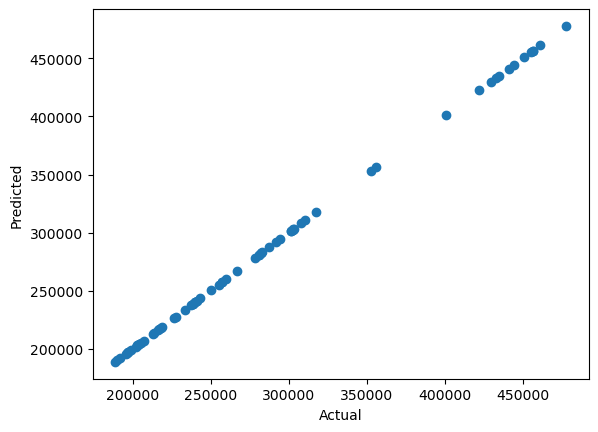

In [43]:
#plot predictions against acutal result
plt.scatter(y_test, test_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

The model has results perfectly fit to a regression line and the R-squared score shows overfitting

I'll use OLS to try to train the model better

In [46]:
#add constant for OLS
import statsmodels.api as sm
X_train_ols, X_test_ols = sm.add_constant(X_train), sm.add_constant(X_test)

In [47]:
#Peform OLS modeling and fitting
ols = sm.OLS(y_train, X_train_ols).fit()

In [48]:
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       mean_sales_price   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.778e+15
Date:                Sun, 18 May 2025   Prob (F-statistic):               0.00
Time:                        19:29:47   Log-Likelihood:                 526.18
No. Observations:                 136   AIC:                            -1024.
Df Residuals:                     122   BIC:                            -983.6
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              2.634e+05      0.002   1.26e+08      0.000    2.63e+05    2.63e+05
pop_rank             -0.0001      0.003     -0.043      0.966      -0.006       0.006
number_of_sales      -0.0011      0.001     -1.038      0.301      -0.003       0.001
home_value         1.025e+05      0.002   4.77e+07      0.000    1.03e+05    1.03e+05
market_heat_index -1.183e-05   2.88e-05     -0.411      0.682   -6.89e-05    4.52e-05
value_surplus      2.722e+04      0.002   1.72e+07      0.000    2.72e+04    2.72e+04
col_0                -0.0018      0.003     -0.539      0.591      -0.008       0.005
col_1                -0.2655      0.298     -0.890      0.375      -0.856       0.325
col_2                -0.0028      0.004     -0.746      0.457      -0.010       0.005
col_3                -0.0029      0.002     -1.297      0.197      -0.007       0.002
col_4                -0.1872      0.356     -0.525      0.600      -0.893       0.518
col_5                -0.0032      0.005     -0.625      0.533      -0.013       0.007
col_6                 0.3551      0.314      1.129      0.261      -0.267       0.978
state_0              -0.0006      0.001     -0.670      0.504      -0.002       0.001
state_1               0.0006      0.001      0.670      0.504      -0.001       0.002
==============================================================================
Omnibus:                        1.656   Durbin-Watson:                   2.171
Prob(Omnibus):                  0.437   Jarque-Bera (JB):                1.244
Skew:                           0.078   Prob(JB):                        0.537
Kurtosis:                       3.442   Cond. No.                     1.44e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.69e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

This model perfectly fits which seems to be a case of sever overfitting. We will have to regularize the data

Test on test data

In [51]:
ols_pred = ols.predict(X_test_ols)

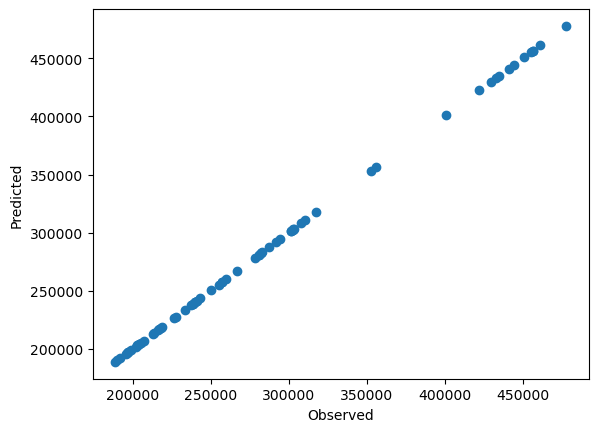

In [52]:
plt.scatter(y_test, ols_pred)
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.show()

We'll use Ridge regression to try to regularize our data

In [54]:
from sklearn.linear_model import Ridge
#test ridge with mutliple alphas
alphas = [0.1, 1.0, 10.0, 100.0, 1000.0]
scores = []
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)
    y_pred = ridge.predict(X_test)
    scores.append(ridge.score(X_test, y_test))

print(scores)

[0.9999814007345085, 0.9987701633441649, 0.9735775203179668, 0.8865915842986583, 0.5425529566327632]


We'll test on alpha=100 as this provided a good R-squared coefficient but leaves enough room to avoid overfitting

In [56]:
ridge_model = Ridge(alpha=100)
ridge_model.fit(X_train, y_train)
ridge_pred = ridge_model.predict(X_test)

In [57]:
ridge_model.score(X_test, y_test)

0.8865915842986583

In [58]:
rmse = np.sqrt(mean_squared_error(y_test, ridge_pred))
print(rmse)

29061.784417488972


The root mean squared error is a little higher than we would have liked as prices range from about 250000 to 500000. Lets visualize the data

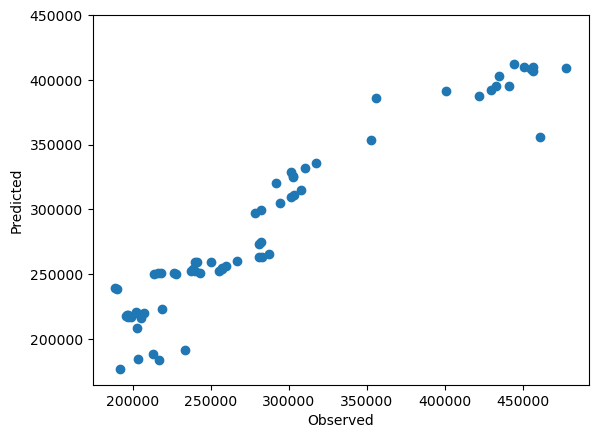

In [60]:
plt.scatter(y_test, ridge_pred)
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.yticks([200000, 250000, 300000, 350000, 400000, 450000])
plt.show()

In [61]:
#set prediction index to compare against test data
ridge_pred = pd.DataFrame(ridge_pred, index=y_test.index)
ridge_pred.head()

,0
date,
2008-04-01,297176.306685
2008-05-01,299381.387004
2008-08-01,190877.083639
2008-09-01,183735.419350
2008-11-01,207874.870130


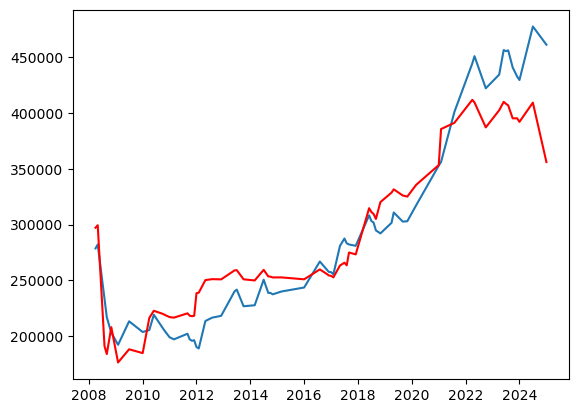

In [62]:
plt.plot(y_test)
plt.plot(ridge_pred, c='red')
plt.show()

Ridge is closely aligned but still gives a little more error than desired in some places. Overall a good result for a balance of generalization and accuracy. I'll try Lasso regression to see how it compares

In [64]:
from sklearn.linear_model import Lasso
alphas = [5000.0, 10000.0, 15000.0, 18000, 20000]
l_scores = []
for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train, y_train)
    y_pred = lasso.predict(X_test)
    l_scores.append(lasso.score(X_test, y_test))

print(l_scores)

[0.9884100831238143, 0.9536478551996119, 0.895721216053684, 0.8508092977233761, 0.8206967821664384]


We had to make the alpha values extremely high to have much affect. We'll try the model with 18000

In [66]:
lasso_model = Lasso(alpha=18000)
lasso.fit(X_train, y_train)
lasso_pred = lasso.predict(X_test)

In [67]:
rmse_lasso = np.sqrt(mean_squared_error(y_test, lasso_pred))
print(rmse_lasso)

36542.11473737998


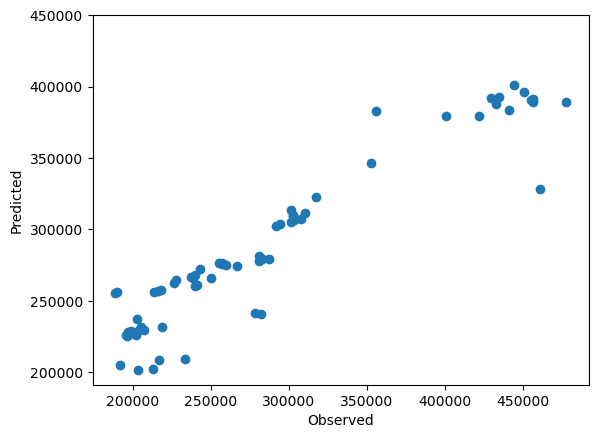

In [68]:
plt.scatter(y_test, lasso_pred)
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.yticks([200000, 250000, 300000, 350000, 400000, 450000])
plt.show()

This fit worse and had a much higher RMSE than Ridge regression so Ridge regression is the top option as of now

<h2>XGBoost</h2>

We'll try XGBoost to minimize RMSE

In [72]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [73]:
from xgboost import XGBRegressor
import xgboost as xg
#Convert to DMatrix objects
xg_model = XGBRegressor(reg_lambda=300,  learning_rate=0.12)
xg_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.12, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [74]:
xg_pred = xg_model.predict(X_test)

In [75]:
xg_model.score(X_test, y_test)

0.886590503267568

In [76]:
rmse_xg = np.sqrt(mean_squared_error(y_test, xg_pred))
print(rmse_xg)

29061.92292845145


In [77]:
print('Max: ', y_train.max(), y_test.max())
print('Min: ', y_train.min(), y_test.min())

Max:  487746.4 477818.64
Min:  192803.51 188783.25


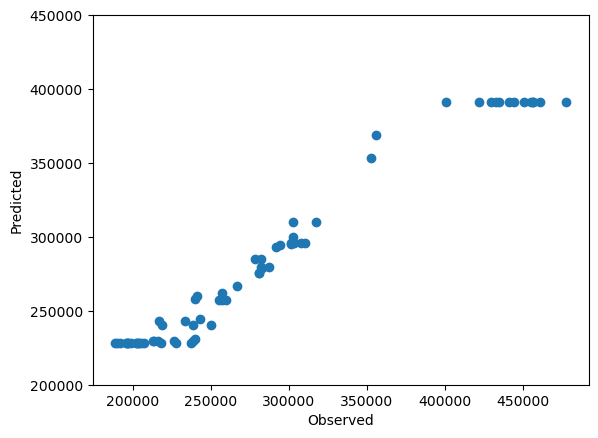

In [78]:
plt.scatter(y_test, xg_pred)
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.yticks([200000, 250000, 300000, 350000, 400000, 450000])
plt.show()

In [79]:
xg_pred = pd.DataFrame(xg_pred, index=y_test.index)
xg_pred.head()

,0
date,
2008-04-01,284707.781250
2008-05-01,284707.781250
2008-08-01,242844.984375
2008-09-01,243289.234375
2008-11-01,228372.343750


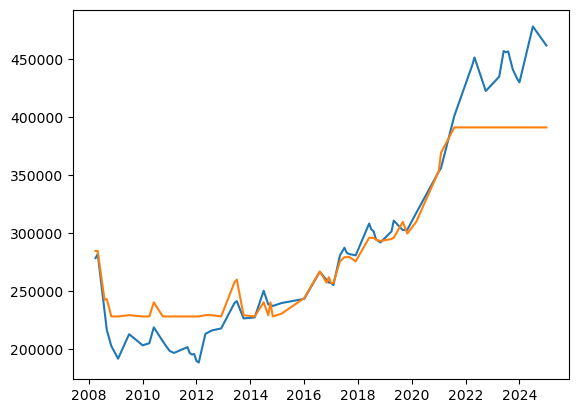

In [80]:
plt.plot(y_test)
plt.plot(xg_pred)
plt.show()

No matter what parameters are put in, the XG model either overfits or caps at certain values. Ridge regression still seems like the best option

<h2>ARIMA</h2>

<h3>Test for stationarity</h3>

In [84]:
#import modules
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

In [85]:
#kpss test for stationarity
from statsmodels.tsa.stattools import kpss
kpss_y = kpss(y_train)
print('p-value: ', kpss_y[1])

p-value:  0.01


/var/folders/95/yr6zk14d0rb52tgyfy426wwh0000gn/T/ipykernel_12631/1873126875.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_y = kpss(y_train)


In [86]:
#ADF test for stationarity
def adf_test(series, significance = 0.05):
    result = adfuller(series, autolag='AIC')
    output = pd.Series(result[0:4], index=['ADF Statistic', 'p-value', 'Lags', 'Observations'])
    for key, value in result[4].items():
        output['Critical Value (%s)'%key] = value
    print(output)
    if result[1] < significance:
        print('time series is stationary')
    else:
        print('time series is non-stationary')

In [87]:
adf_test(y_train)

ADF Statistic             1.346223
p-value                   0.996856
Lags                      5.000000
Observations            130.000000
Critical Value (1%)      -3.481682
Critical Value (5%)      -2.884042
Critical Value (10%)     -2.578770
dtype: float64
time series is non-stationary


The tests confirm our training data is non-stationary so we will need to transform it

<Axes: xlabel='date'>

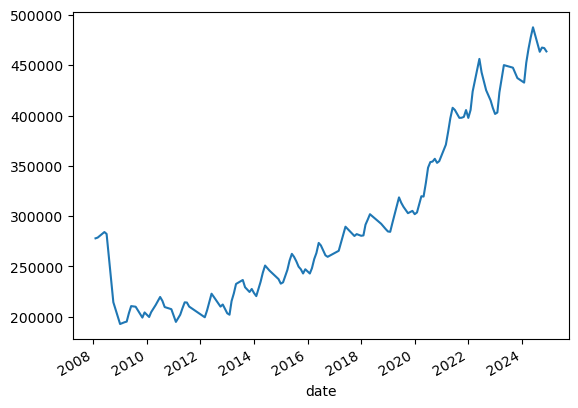

In [89]:
#view data
y_train.plot()

Take log of data to get constant variance

<Axes: xlabel='date'>

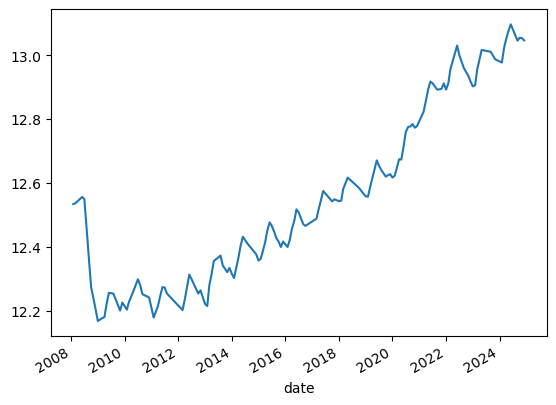

In [91]:
y_log = np.log(y_train)
y_log.plot()

To get constant mean, we'll difference the data 

In [93]:
y_diff = y_log.diff().dropna()
kpss_log = kpss(y_diff)
print('p-value: ', kpss_log[1])

p-value:  0.1


/var/folders/95/yr6zk14d0rb52tgyfy426wwh0000gn/T/ipykernel_12631/3015209065.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_log = kpss(y_diff)


In [94]:
adf_test(y_diff)

ADF Statistic          -8.092870e+00
p-value                 1.363368e-12
Lags                    4.000000e+00
Observations            1.300000e+02
Critical Value (1%)    -3.481682e+00
Critical Value (5%)    -2.884042e+00
Critical Value (10%)   -2.578770e+00
dtype: float64
time series is stationary


Now the data is confirmed by both tests to be stationary and we can model

<h3>Modeling</h3>

Function to find MSE

In [98]:
def mse_arima(data, arima_order):
    #change dtype to int to use as index later
    split = int(len(data) * 0.8)
    #Create train/test variables
    train, test = data[0:split], data[split:len(data)]
    past= [x for x in train]
    #predictions
    predictions = list()
    #comparison between test data & one-stop prediction ARIMA model
    for i in range(len(test)):
        model=ARIMA(past, order=arima_order)
        model_fit = model.fit()
        future= model_fit.forecast()[0]
        predictions.append(future)
        past.append(test[i])
    #Calculate sample error
    error = mean_squared_error(test, predictions)
    return error

Function to evaluate ARIMA model order

In [100]:
def evaluate_models(dataset, p_values, d_values, q_values):
    best_score = float('inf')
    best_cfg = None
    #iterate through p, then d, then q values
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                #see if mse if less than best score
                try:
                    mse = mse_arima(dataset, order)
                    if mse < best_score:
                        best_score = mse 
                        best_cfg = order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    return print('Best ARIMA:', best_cfg, ' MSE:', best_score)

In [101]:
#set p, d, q values to test
p_values = [0, 1, 2]
d_values = [0, 1, 2]
q_values = [0, 1, 2]

In [102]:
import warnings
warnings.filterwarnings("ignore")
#find optimum ARIMA order
evaluate_models(y_log, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=0.233
ARIMA(0, 0, 1) MSE=0.063
ARIMA(0, 0, 2) MSE=0.022
ARIMA(0, 1, 0) MSE=0.001
ARIMA(0, 1, 1) MSE=0.001
ARIMA(0, 1, 2) MSE=0.001
ARIMA(0, 2, 0) MSE=0.001
ARIMA(0, 2, 1) MSE=0.001
ARIMA(0, 2, 2) MSE=0.001
ARIMA(1, 0, 0) MSE=0.001
ARIMA(1, 0, 1) MSE=0.001
ARIMA(1, 0, 2) MSE=0.001
ARIMA(1, 1, 0) MSE=0.001
ARIMA(1, 1, 1) MSE=0.001
ARIMA(1, 1, 2) MSE=0.001
ARIMA(1, 2, 0) MSE=0.001
ARIMA(1, 2, 1) MSE=0.001
ARIMA(1, 2, 2) MSE=0.001
ARIMA(2, 0, 0) MSE=0.001
ARIMA(2, 0, 1) MSE=0.001
ARIMA(2, 0, 2) MSE=0.002
ARIMA(2, 1, 0) MSE=0.001
ARIMA(2, 1, 1) MSE=0.001
ARIMA(2, 1, 2) MSE=0.001
ARIMA(2, 2, 0) MSE=0.001
ARIMA(2, 2, 1) MSE=0.001
ARIMA(2, 2, 2) MSE=0.001
Best ARIMA: (2, 1, 1)  MSE: 0.000677368681878312


The best p,d,q values are 2,1,1 so we'll fit an ARIMAX model with that and bring in our X data

In [104]:
a_model = ARIMA(y_log, exog=X_train, order=(2,1,1))
arima_fit = a_model.fit()

In [105]:
arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       mean_sales_price   No. Observations:                  136
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 475.454
Date:                Sun, 18 May 2025   AIC                           -914.909
Time:                        19:33:01   BIC                           -862.614
Sample:                             0   HQIC                          -893.658
                                - 136                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
pop_rank              0.0200      0.010      2.012      0.044       0.001       0.040
number_of_sales       0.0059      0.003      2.297      0.022       0.001       0.011
home_value            0.2860      0.019     14.937      0.000       0.249       0.324
market_heat_index     0.0002   8.76e-05      2.149      0.032    1.66e-05       0.000
value_surplus         0.0837      0.003     31.810      0.000       0.079       0.089
col_0                -0.0018      0.013     -0.142      0.887      -0.027       0.023
col_1                 0.8193      0.595      1.378      0.168      -0.346       1.985
col_2                -0.0156      0.017     -0.939      0.348      -0.048       0.017
col_3                -0.0075      0.013     -0.563      0.573      -0.033       0.019
col_4                 3.7490      1.674      2.240      0.025       0.469       7.029
col_5                -0.0259      0.020     -1.281      0.200      -0.066       0.014
col_6                 0.1479      1.370      0.108      0.914      -2.538       2.834
state_0               0.0075      0.004      1.786      0.074      -0.001       0.016
state_1              -0.0079      0.004     -1.873      0.061      -0.016       0.000
ar.L1                 0.9939      0.127      7.800      0.000       0.744       1.244
ar.L2                -0.3986      0.109     -3.673      0.000      -0.611      -0.186
ma.L1                -0.7233      0.142     -5.110      0.000      -1.001      -0.446
sigma2             5.072e-05   6.08e-06      8.347      0.000    3.88e-05    6.26e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                17.03
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.77   Skew:                            -0.21
Prob(H) (two-sided):                  0.38   Kurtosis:                         4.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.18e+21. Standard errors may be unstable.
"""

Very low AIC and BIC means the model is strong but it may be overfit. 

In [107]:
forecast_log = arima_fit.predict()
forecast_log

date
2008-02-01     0.125467
2008-03-01    12.539463
2008-06-01    12.558885
2008-07-01    12.552244
2008-10-01    12.283330
                ...    
2024-08-01    13.048359
2024-09-01    13.045885
2024-10-01    13.055458
2024-11-01    13.050417
2024-12-01    13.053575
Name: predicted_mean, Length: 136, dtype: float64

In [108]:
#transforming log data back to exponents to compare against our test data
forecast_actual = np.exp(forecast_log)
forecast_actual

date
2008-02-01         1.133678
2008-03-01    279138.472824
2008-06-01    284612.783530
2008-07-01    282728.880728
2008-10-01    216064.059360
                  ...      
2024-08-01    464333.613769
2024-09-01    463186.511739
2024-10-01    467641.877438
2024-11-01    465290.388832
2024-12-01    466761.898434
Name: predicted_mean, Length: 136, dtype: float64

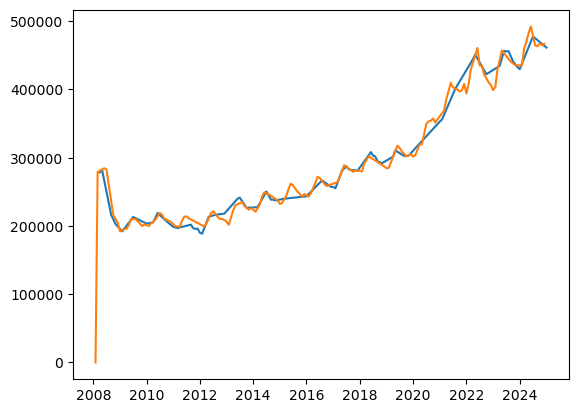

In [109]:
plt.plot(y_test)
plt.plot(forecast_actual)
plt.show()

This also looks overfit. The best option for modeling will be Ridge Regression

<h1>Forecasting</h1>

In [112]:
#Create future dates for 5 years from the end of your training data
last_date = X.index.max()
future_dates = pd.date_range(start=pd.to_datetime(f'2025-{last_date.month + 1}-01'), periods=60, freq='M')
future_df = pd.DataFrame(index=future_dates, columns=X.columns)
prediction_X = pd.concat([X, future_df])
prediction_X

,pop_rank,number_of_sales,home_value,market_heat_index,value_surplus,col_0,col_1,col_2,col_3,col_4,col_5,col_6,state_0,state_1
2008-02-01,82.01,1895.04,220376.07,61.1,57596.14,0.12,0.18,0.1,0.16,0.13,0.17,0.14,0.46,0.54
2008-03-01,82.01,2049.45,218493.99,61.1,60187.98,0.12,0.18,0.1,0.16,0.13,0.17,0.14,0.46,0.54
2008-04-01,82.01,2166.77,216616.83,61.1,61950.63,0.12,0.18,0.1,0.16,0.13,0.17,0.14,0.46,0.54
2008-05-01,82.01,2275.40,214668.16,61.1,67417.58,0.12,0.18,0.1,0.16,0.13,0.17,0.14,0.46,0.54
2008-06-01,82.01,2351.13,212744.93,61.1,71466.46,0.12,0.18,0.1,0.16,0.13,0.17,0.14,0.46,0.54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2029-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2029-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2029-11-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2029-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [113]:
# Prepare future input features for 5 years (60 months)
X_scale = scaler.transform(X)
X_forecast = pd.DataFrame(X_scale, index=X.index, columns=X.columns)
last_data = X_forecast.iloc[[-1]].values.tolist()[0]
future_dates = pd.to_datetime(pd.date_range(start=X_forecast.index[-1] + pd.DateOffset(months=1), periods=60, freq='M'))
future_predictions = []

for i in range(60):
    prediction = ridge_model.predict(np.array(last_data).reshape(1, -1))[0].round(2)
    future_predictions.append(prediction)
    last_data.insert(0, prediction)
    last_data.pop()
    
future_df = pd.DataFrame({'date': future_dates, 'mean_sales_price': future_predictions})
future_df.set_index('date', inplace=True)
future_df.head()

,mean_sales_price
date,
2025-02-28,3.560896e+05
2025-03-31,3.500704e+09
2025-04-30,3.441461e+13
2025-05-31,3.383220e+17
2025-06-30,3.325965e+21


In [114]:
future_df['mean_sales_price'] = future_df['mean_sales_price'].round(2)
future_df

,mean_sales_price
date,
2025-02-28,3.560896e+05
2025-03-31,3.500704e+09
2025-04-30,3.441461e+13
2025-05-31,3.383220e+17
2025-06-30,3.325965e+21
2025-07-31,3.269679e+25
2025-08-31,3.214345e+29
2025-09-30,3.159948e+33
2025-10-31,3.106471e+37


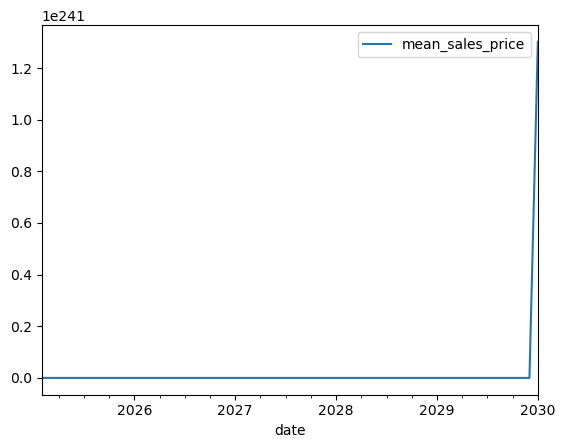

In [115]:
future_df.plot()
plt.show()

In [116]:
pip install skforecast

Note: you may need to restart the kernel to use updated packages.


In [134]:
#train forecaster model with Ridge Regression
from skforecast.recursive import ForecasterRecursive
forecaster = ForecasterRecursive(regressor=ridge_model,
                                lags=24)
forecaster.fit(y)

In [118]:
#predictions
steps = 60 #predicting 5 years of data
predictions = forecaster.predict(steps=steps).round(2)
predictions.head()

60    468820.33
61    497689.81
62    524218.76
63    539505.90
64    542002.29
Name: pred, dtype: float64

In [119]:
#create index for predictions
future_dates = pd.date_range(start='2025-02-01', end='2030-02-01', freq='ME')
predictions = pd.DataFrame(predictions)
predictions = predictions.set_index(future_dates)
predictions.head()

,pred
2025-02-28,468820.33
2025-03-31,497689.81
2025-04-30,524218.76
2025-05-31,539505.90
2025-06-30,542002.29


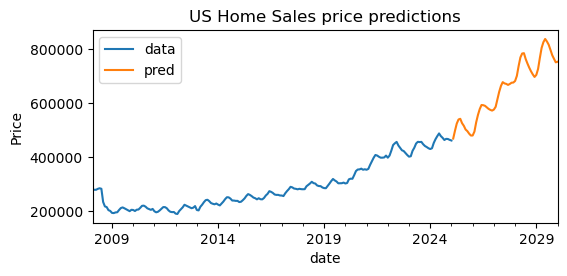

In [120]:
#plot predictions
fig, ax = plt.subplots(figsize=(6, 2.5))
y.plot(ax=ax, label='data')
predictions.plot(ax=ax, label='predictions')
ax.legend()
plt.ylabel('Price')
plt.title('US Home Sales price predictions')
plt.show()

In [121]:
print('The average US home price in 2030 will be', predictions.iloc[-1, 0].round(2), 'USD')

The average US home price in 2030 will be 753856.07 USD


Now we will break down the data for each state and compare

First, separate the original data into states

In [124]:
state_data = data.drop(columns='city')
group_by_state = state_data.groupby(['state', 'date']).median().round(2)
group_by_state = group_by_state.reset_index('date')
group_by_state.head()

,date,pop_rank,mean_sales_price,number_of_sales,home_value,market_heat_index,value_surplus
state,,,,,,,
AL,2008-02-01,127.0,399947.0,1538.5,143938.10,50.0,285292.55
AL,2008-03-01,127.0,399947.0,1538.5,143864.44,50.0,285489.84
AL,2008-04-01,127.0,399947.0,1538.5,143948.49,50.0,286885.81
AL,2008-05-01,127.0,399947.0,1538.5,143990.45,50.0,288473.31
AL,2008-06-01,127.0,399947.0,1538.5,143969.26,50.0,289815.18


Now we will create a dictionary for the dfs of each state

In [126]:
uniqueState = list(state_data.state.unique())
uniqueState

['OH',
 'NY',
 'NM',
 'PA',
 'NC',
 'GA',
 'TX',
 'CA',
 'MD',
 'MA',
 'LA',
 'OR',
 'AL',
 'ID',
 'CT',
 'FL',
 'SC',
 'TN',
 'IL',
 'CO',
 'IA',
 'MI',
 'AR',
 'IN',
 'MS',
 'MO',
 'NV',
 'KY',
 'WI',
 'MN',
 'OK',
 'NE',
 'AZ',
 'ME',
 'RI',
 'UT',
 'VA',
 'DE',
 'WA',
 'KS',
 'HI']

In [127]:
state_dfs = {}
for state in uniqueState:
    state_dfs[state] = group_by_state[group_by_state.index == state].copy()

state_dfs

{'OH':             date  pop_rank  mean_sales_price  number_of_sales  home_value  \
 state                                                                       
 OH    2008-02-01      83.0         120216.25           1232.0   124307.87   
 OH    2008-03-01      83.0         119278.00           1434.0   124112.73   
 OH    2008-04-01      83.0         118531.00           1536.0   124067.90   
 OH    2008-05-01      83.0         135424.00           1536.0   124246.82   
 OH    2008-06-01      83.0         137244.50           1536.0   124224.50   
 ...          ...       ...               ...              ...         ...   
 OH    2024-09-01      83.0         240604.75           1536.0   211943.33   
 OH    2024-10-01      83.0         236454.75           1536.0   212370.67   
 OH    2024-11-01      83.0         225720.80           1536.0   212962.93   
 OH    2024-12-01      83.0         228519.50           1536.0   214113.06   
 OH    2025-01-01      83.0         184501.00           14

In [313]:
#predict on each state
future_home_prices = {}
for state in state_dfs:
    indexed_df = state_dfs[state].reset_index().set_index('date')
    y = indexed_df['mean_sales_price']
    forecaster = ForecasterRecursive(ridge_model, lags=24)
    forecaster.fit(y)
    predictions = forecaster.predict(steps=steps).round(2)
    predictions = pd.DataFrame(predictions)
    predictions = predictions.set_index(future_dates)
    future_home_prices[state] = predictions.iloc[-1, 0].round(2)

In [315]:
future_home_prices = dict(sorted(future_home_prices.items(), key=lambda item: item[1], reverse=True))
future_home_prices

{'NM': 1844072.51,
 'HI': 1160246.05,
 'RI': 1157088.46,
 'NV': 1121203.83,
 'ME': 1042779.41,
 'MA': 1034306.53,
 'WA': 1005279.72,
 'DE': 871454.22,
 'CT': 841853.29,
 'CA': 823924.79,
 'CO': 793746.71,
 'UT': 782052.22,
 'OR': 735743.19,
 'ID': 699297.64,
 'VA': 698320.23,
 'AZ': 693049.84,
 'TN': 661314.9,
 'WI': 658612.78,
 'SC': 628186.95,
 'GA': 612503.03,
 'FL': 609109.05,
 'KY': 603718.58,
 'NE': 590175.9,
 'AR': 589464.85,
 'MN': 585174.51,
 'PA': 576684.58,
 'MS': 521244.64,
 'MD': 488330.64,
 'IA': 481995.21,
 'IL': 455899.8,
 'IN': 443376.27,
 'NC': 442555.71,
 'NY': 442152.39,
 'OK': 436842.48,
 'MI': 367622.04,
 'MO': 358464.85,
 'TX': 354175.4,
 'KS': 349759.01,
 'LA': 328529.34,
 'AL': 278667.56,
 'OH': 275177.31}

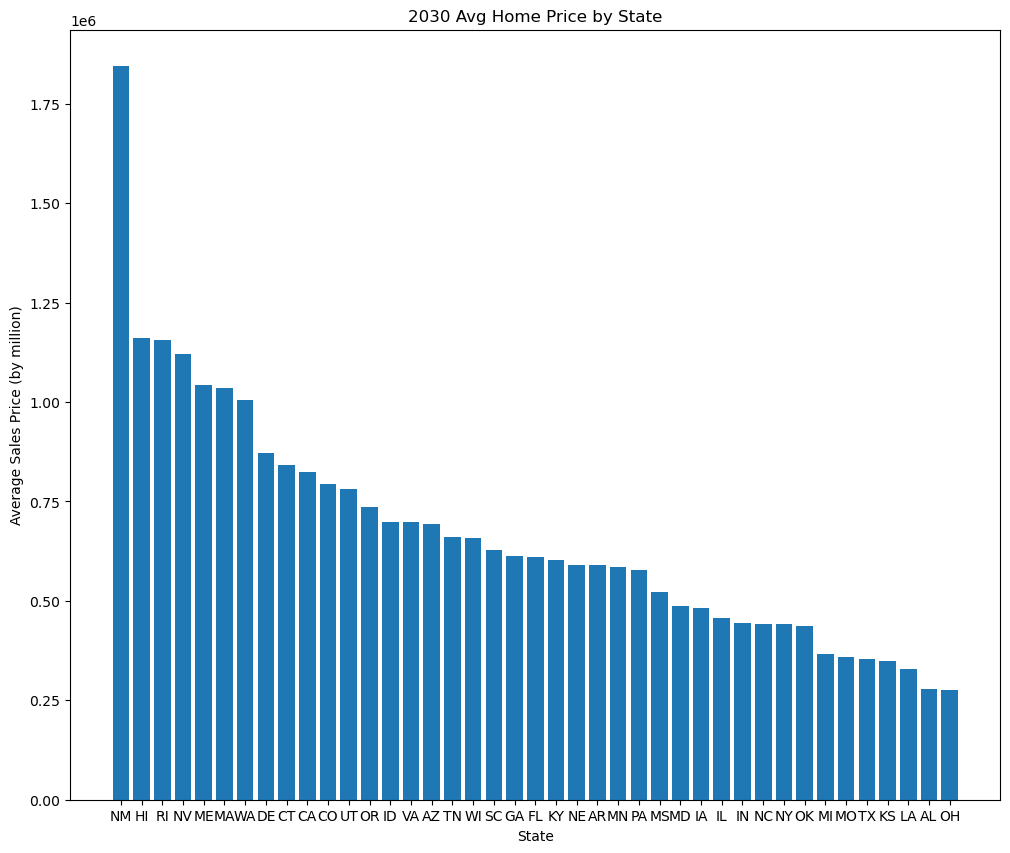

In [329]:
#plot data
fig, ax = plt.subplots(figsize=(12, 10))
plt.bar(future_home_prices.keys(), future_home_prices.values())
plt.xlabel('State')
plt.ylabel('Average Sales Price (by million)')
plt.title('2030 Avg Home Price by State')
plt.show()

Our model results in New Mexico having the highest average home price in 2030 at 1,844,072